In [1]:
import IPython.display
IPython.display.HTML("<style>.container { width:100% !important; margin: 0 auto; }</style>")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import annoy
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
from boiler.vqvae import VQVAE2
from boiler.mel import Audio2Mel
from boiler.dataset import WavFile
from boiler.train_vqvae import make_dataloader

In [5]:
!ls -lahctr exp/d | tail -2

-rw-rw-r-- 1 proger proger 7.1M Nov 20 19:37 vqvae_057.pt
-rw-rw-r-- 1 proger proger  95M Nov 20 19:37 events.out.tfevents.1605891462.rt.2472126.0


In [6]:
model = VQVAE2().to('cuda')
model.load_state_dict(torch.load('exp/d/vqvae_043.pt'))

<All keys matched successfully>

In [7]:
fft = Audio2Mel(n_mel_channels=80).cuda()

In [78]:
wav_dir = Path('/home/proger/coub-crawler/monthlyLog/wav/')
wavi = [WavFile(wav) for wav in wav_dir.glob('*.wav')]

batch_size = 16
loader = make_dataloader(wav_dir, batch_size=batch_size)

index = annoy.AnnoyIndex(512, 'euclidean')
for batch_number, batch in enumerate(tqdm(loader)):
    bag, _ = model.encode_bag_t(fft(batch.cuda()).unsqueeze(1))
    for i, vec in enumerate(bag.split(1), start=batch_size*batch_number):
        #wavi[i] = k

        index.add_item(i, vec.view(-1))
        
index.build(100)

100%|██████████| 584/584 [01:21<00:00,  7.16it/s]


True

In [79]:
index.get_nns_by_item(3253, 10)

[3253, 2482, 1595, 6101, 9245, 5513, 6882, 1470, 3476, 8346]

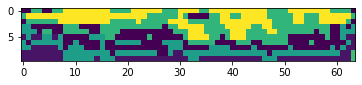

In [80]:
plt.imshow(model.encode(query.unsqueeze(0))[-2].squeeze().cpu().numpy())

query w9b6h


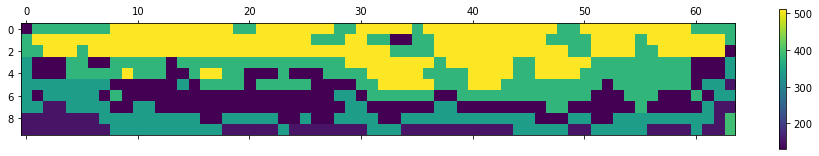

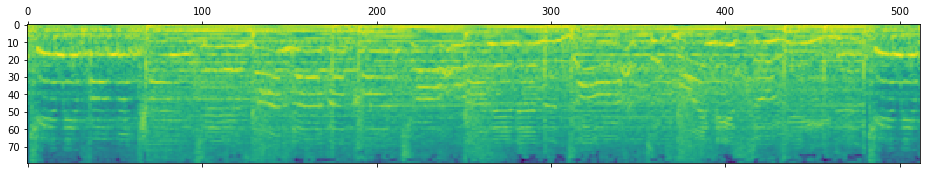

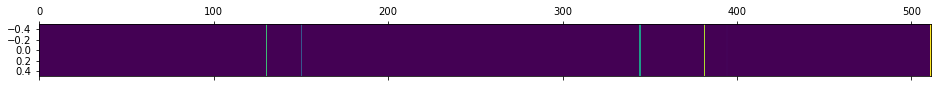

# result 7832 22wmvp 0.046862367540597916


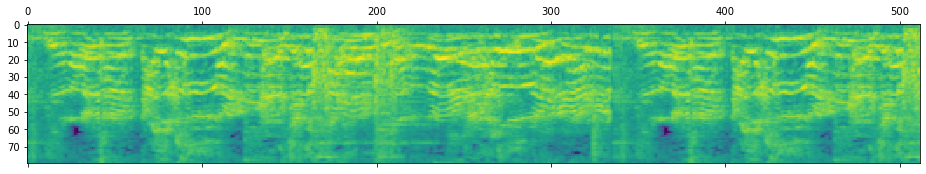

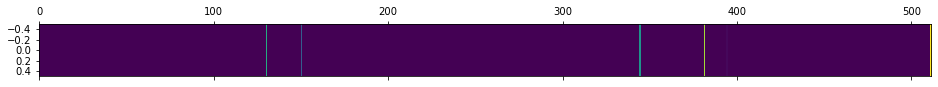

# result 8429 26i0k7 0.04913077503442764


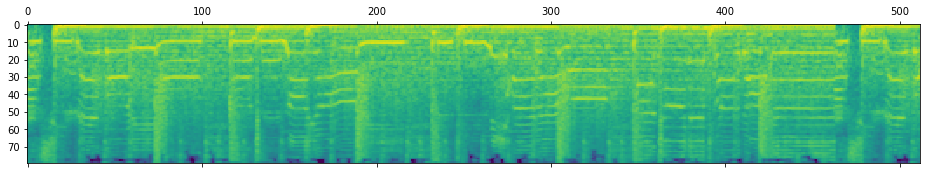

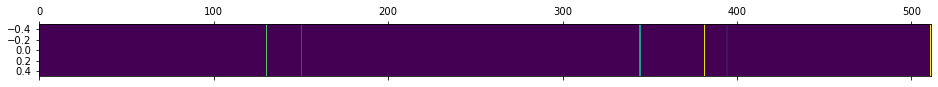

# result 5467 2e276k 0.06427906453609467


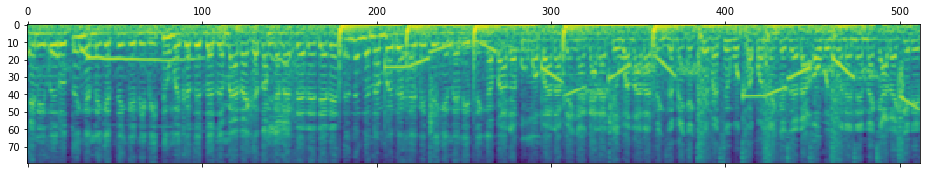

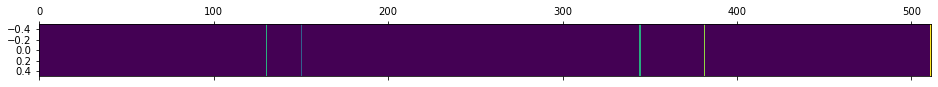

# result 9087 1la3hm 0.07102462649345398


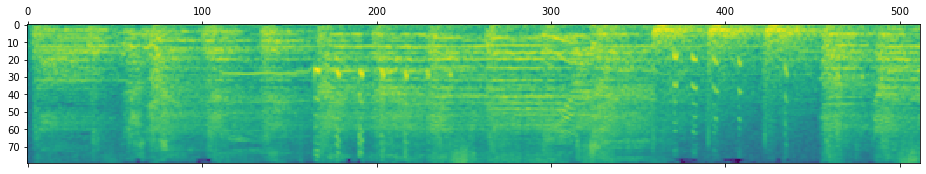

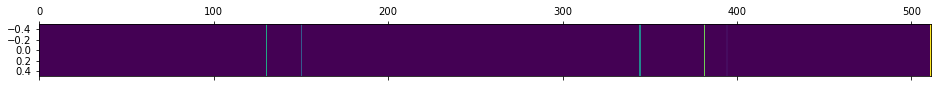

# result 5704 1ferx7 0.0802839919924736


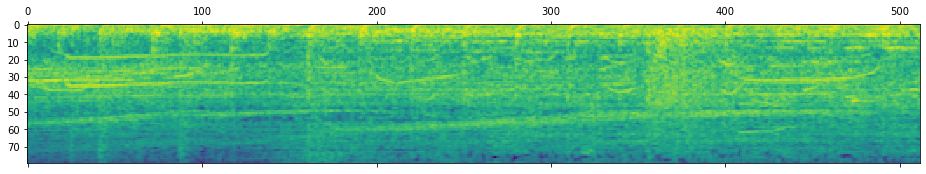

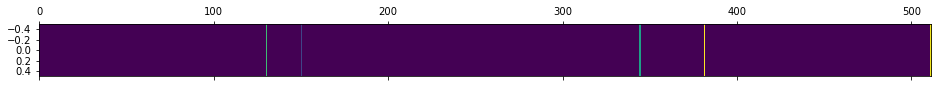

# result 6282 15flc8 0.08326654136180878


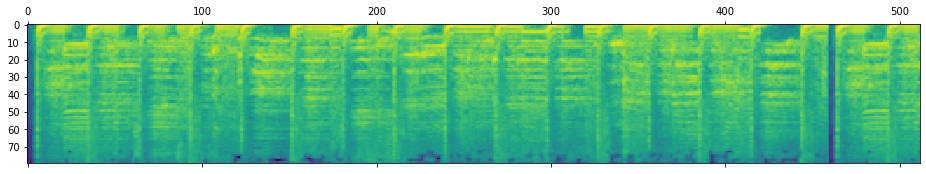

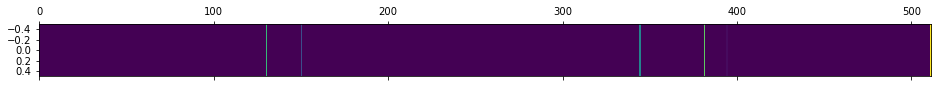

# result 8373 2kvjar 0.09148860722780228


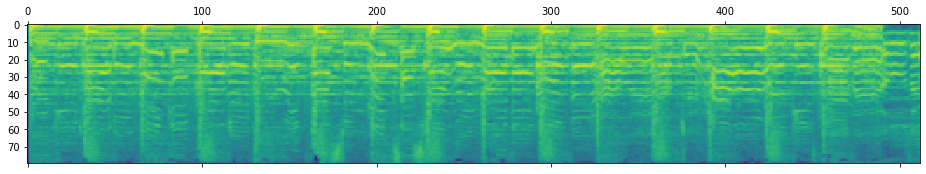

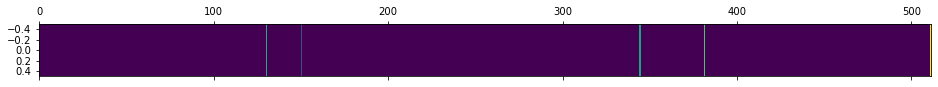

# result 5656 2iw9vl 0.09229526668787003


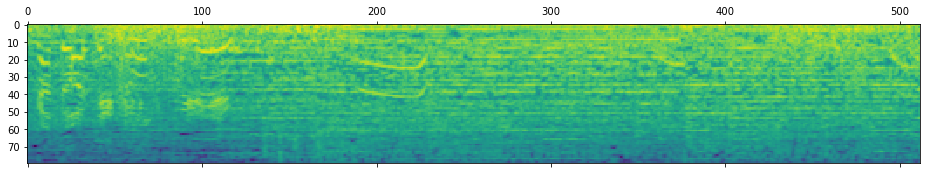

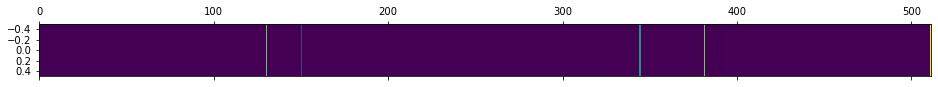

# result 7434 2ctkpi 0.09383966028690338


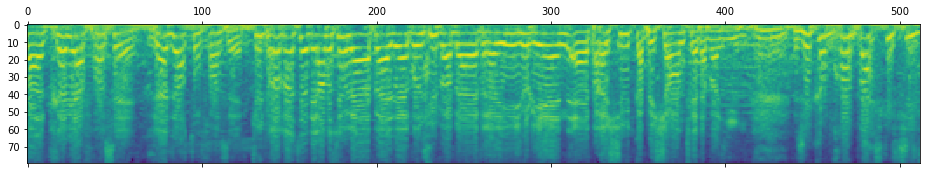

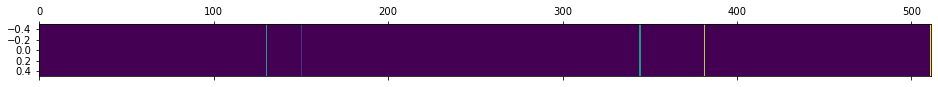

# result 9302 1hba0b 0.10182607173919678


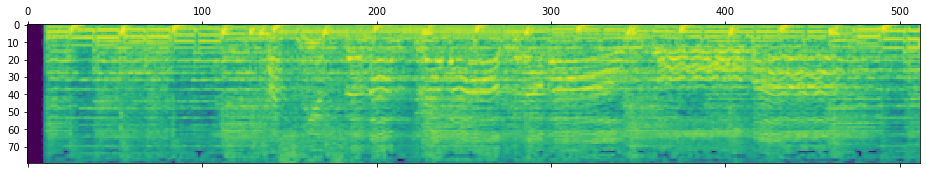

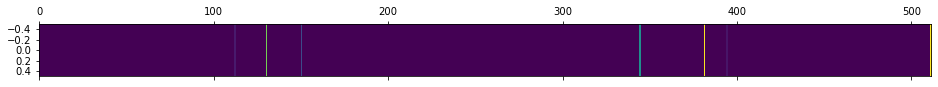

In [82]:
q = wavi[300]
query_audio = q[0]
query_key = q.filename.stem
query = fft(query_audio.unsqueeze(0).cuda())
vec, id_b = model.encode_bag_t(query.unsqueeze(0))
vec = vec.squeeze()

print('query', query_key)
plt.matshow(id_b.detach().cpu().squeeze())
plt.colorbar()

plt.matshow(query.detach().cpu().squeeze())
plt.show()
plt.matshow(vec.detach().cpu()[None,:], aspect=30)
plt.show()
IPython.display.display(IPython.display.Audio(query_audio, rate=16000))

for i, dist in zip(*index.get_nns_by_vector(vec, 10, include_distances=True)):
    print('# result', i, wavi[i].filename.stem, dist)
    audio = wavi[i][0]
    plt.matshow(fft(audio.unsqueeze(0).cuda()).detach().cpu().squeeze())
    plt.show()
    plt.matshow(torch.tensor(index.get_item_vector(i))[None,:], aspect=30)
    plt.show()
    IPython.display.display(IPython.display.Audio(audio, rate=16000))